<a href="https://colab.research.google.com/github/osamazafar980/About-Us-Page-React-JS/blob/main/Collaborative_Agriculture_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import time
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import confusion_matrix
import warnings
import joblib
from scipy.stats import laplace

Defining Utility Functions

In [ ]:
def standardize_data(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

def calculateSensitivities(df):
  sens = []
  for col in df.columns:
    sens.append(max(abs(df[col].max() - df[col].min()), 1))
  return sens


def add_noise(sample,sens,esps):
  newSample = np.zeros_like(sample)
  for idx in range(len(sample)):
    value = sample[idx]
    noise = np.random.laplace(scale= sens[idx] / esps[idx])
    newSample[idx] = value + noise
  return newSample



def laplace_mechanism_2d(data, esp):
    newData = np.zeros_like(data)
    ndf = pd.DataFrame(data)
    sens = calculateSensitivities(ndf)
    totalEsp = esp
    esps = [totalEsp/len(sens)]*len(sens)
    print(esps)
    for i in range(len(data)):
      newData[i] = add_noise(data[i], sens, esps)
    return newData



# Function to transform data using PCA and add Laplace noise
def pca_with_noise(data, n_components, epsilon):
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data)
    scale = 1 / epsilon
    noise = laplace.rvs(scale=scale, size=pca_data.shape)
    noisy_pca_data = pca_data + noise
    return noisy_pca_data, pca

# Function to compute Euclidean distances
def compute_euclidean_distances(data1, data2):
    return euclidean_distances(data1, data2)

# Function to determine the threshold
def determine_threshold(distances, false_positive_rate=0.05):
  # distances = [d.min() for d in distances]
  # threshold = np.percentile(distances, 100 * (1 - false_positive_rate))
  threshold_index = int(len(distances.flatten()) * false_positive_rate)
  threshold = np.sort(distances.flatten())[threshold_index]
  return threshold

# Function to calculate the power
def calculate_power(researcher_data, control_group, case_group, threshold):
    case_distances = compute_euclidean_distances(researcher_data, case_group)
    count = np.sum([distance.min() < threshold for distance in case_distances])
    power = count / case_group.shape[0]
    return power

# Function to add Laplace noise
def add_laplace_noise(data, epsilon):
    scale = 1 / epsilon
    noise = laplace.rvs(scale=scale, size=data.shape)
    return data + noise

# Function to sample data
def data_sampling(population, pca_model, pop_a_label, pop_b_label, pop):
    pop_a = population[population.label == pop_a_label]
    pop_a_1 = pop_a.sample(frac=0.5)
    pop_a_2 = pop_a.loc[~pop_a.index.isin(pop_a_1.index)]

    pop_b = population[population.label == pop_b_label]
    pop_b_1 = pop_b.sample(frac=0.5)
    pop_b_2 = pop_b.loc[~pop_b.index.isin(pop_b_1.index)]

    if pop == 1:
        researcher_1 = pop_a_1
        researcher_2 = pop_b_1
    else:
        researcher_1 = pd.concat([pop_a_1, pop_b_1])
        researcher_2 = pd.concat([pop_a_2, pop_b_2])

    not_r1 = population[~population.index.isin(researcher_1.index)]
    control_group = not_r1.groupby('label').sample(n=int(researcher_1.shape[0] / 3) - 1)

    researcher_1 = pca_model.transform(researcher_1.iloc[:, :-1])
    researcher_2 = pca_model.transform(researcher_2.iloc[:, :-1])
    control_group = pca_model.transform(control_group.iloc[:, :-1])
    case_group = researcher_1[np.random.choice(researcher_1.shape[0], control_group.shape[0], replace=False)]

    return researcher_1, researcher_2, control_group, case_group

def addNoise(pca1,epsilon):
  noisy_X1 = np.zeros_like(pca1, dtype=float)
  sen = np.array(calculateSensitivities(pd.DataFrame(pca1)))
  esps = np.array([epsilon/len(sen)]*len(sen))
  scales = sen / esps
  # Add Laplace noise to each column of PCA1
  for i in range(pca1.shape[1]):
      # Generate Laplace noise
      noise = np.random.laplace(0, scales[i], size=pca1.shape[0])
      # Add noise to the column
      noisy_X1[:, i] = pca1[:, i] + noise
  return noisy_X1

# Function to run the experiment
def exp_run(data,n_pop, pca_model,r1):
    power_results = []
    epsilon_values = np.arange(10, 120, 10)
    for epsilon in epsilon_values:
        not_n_pop = 0 if n_pop == 1 else 1
        researcher_1 = r1[np.random.choice(np.where(y1_kmeans == n_pop)[0], size=40, replace=False)]
        control_group = X_pca[np.random.choice(len(X_pca), size=40, replace=False)]
        case_group = X_pca[np.random.choice(np.where(y_kmeans == n_pop)[0], size=40, replace=False)]
        researcher_1_noisy = addNoise(researcher_1, epsilon)

        control_distances = compute_euclidean_distances(control_group, researcher_1_noisy)

        threshold = determine_threshold(control_distances)

        power = calculate_power(researcher_1_noisy, control_group, case_group, threshold)

        power_results.append((epsilon, power))

    power_df = pd.DataFrame(power_results, columns=['epsilon', 'power'])
    return power_df



In [ ]:
n_clusters = 3
df = pd.read_csv('MI_Vendor_Data_V2.csv')
df = df.fillna(0)
df = df.replace(['Yes'], 1)
df = df.replace(['No'], 0)
df['Sales'] = df['Sales'].str.replace('$','')
df['Sales'] = df['Sales'].str.replace(',','')
X = df.drop(df.columns[[0]], axis=1, inplace=False).values
X = standardize_data(X.astype('float64'))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pcaGlobal = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pcaGlobalData = pcaGlobal.fit_transform(X)
df['clusterLabel'] = kmeans.fit_predict(pcaGlobalData)
orignalClusterCenters = kmeans.cluster_centers_
df = df.sample(frac=1).reset_index(drop=True)
# Sampling bais for mantinaing cluster population in divided pices.
cluster_counts = df['clusterLabel'].value_counts()
biased_proportions = cluster_counts / cluster_counts.sum()
#overriting biased proportions to priortise cluster 0 and introduce biase by switching values for cluster 0 and 1
n = len(df)
n_50 = int(n * 0.5)
n_25_1 = int(n * 0.25)
print
sample_50 = df.sample(n=n_50, weights=df['clusterLabel'].map(biased_proportions))
df_remaining = df.drop(sample_50.index)
sample_25_1 = df_remaining.sample(n=n_25_1)
df_remaining = df_remaining.drop(sample_25_1.index)
sample_25_2 = df_remaining  # This is the rest of the DataFrame
sample_50 = sample_50.drop(columns=['clusterLabel'])
sample_50.to_csv('MI_Vendor_Data_Global.csv', index=False)
sample_25_1.drop(columns=['clusterLabel']).to_csv('MI_Vendor_Data_1.csv',index=False)
sample_25_2.drop(columns=['clusterLabel']).to_csv('MI_Vendor_Data_2.csv', index=False)
truth = sample_25_1['clusterLabel'].values
sample_25_1.loc[:, sample_25_1.columns.intersection(['ID','clusterLabel'])].to_csv('MI_Vendor_Data_GroundTruth.csv', index=False)
truth = pd.read_csv('MI_Vendor_Data_GroundTruth.csv')
truth['clusterLabel'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count
clusterLabel,
1,63
0,53
2,4


Loading Seperated Datasets

In [ ]:
df_MI_Global = pd.read_csv('MI_Vendor_Data_Global.csv')
df_MI_1 = pd.read_csv('MI_Vendor_Data_1.csv')
df_MI_2 = pd.read_csv('MI_Vendor_Data_2.csv')
df_MI_Global.head()


,ID,Miles from Market - Primary Location,Fruits & Vegetables - Vendor Type,Meat & Seafood - Vendor Type,Dairy - Vendor Type,Eggs - Vendor Type,Plants & Flowers - Vendor Type,Nuts & Legumes - Vendor Type,Value-added - Vendor Type,Prepared Food - Vendor Type,Crafts/Art/Services - Vendor Type,Sales,Visitor Count
0,6388,0.00,0,0,0,0,0,0,1,0,0,225.0,70
1,6803,12.79,1,1,0,0,1,0,0,0,0,100.0,457
2,6677,19.68,0,0,0,0,0,0,0,0,0,446.0,230
3,6374,18.28,1,0,0,0,0,0,1,0,0,425.0,283
4,6396,5.36,1,0,1,1,0,0,1,0,0,1573.0,6


PCA Function

In [ ]:

#Step 1: Data preprocessing
X = df_MI_Global.drop(df_MI_Global.columns[[0]], axis=1, inplace=False).values
X = standardize_data(X.astype('float64'))
# pcaGlobal = pcaGlobal.fit(X_scaled)
X_pca = pcaGlobal.transform(X)

X1 = df_MI_1.drop(df_MI_1.columns[[0]], axis=1, inplace=False).values
X1 = standardize_data(X1.astype('float64'))
pca1 = pcaGlobal.transform(X1)

X2 = df_MI_2.drop(df_MI_2.columns[[0]], axis=1, inplace=False).values
X2 = standardize_data(X2.astype('float64'))
pca2 = pcaGlobal.transform(X2)

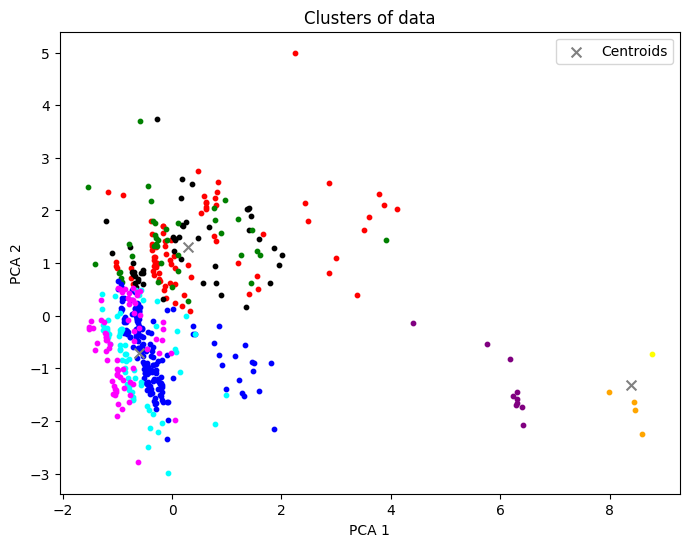

In [ ]:

# Step: Apply K-Means Clustering
y_kmeans = kmeans.predict(X_pca)
globalClusterCenters = kmeans.cluster_centers_
y1_kmeans = kmeans.predict(pca1)
y2_kmeans = kmeans.predict(pca2)

# Step: Plot the clusters
plt.figure(figsize=(8, 6))
colors = ['red', 'black', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'brown']
for i in range(n_clusters):
    plt.scatter(X_pca[y_kmeans == i, 0], X_pca[y_kmeans == i, 1], s=10, c=colors[3*i])
    plt.scatter(pca1[y1_kmeans == i, 0], pca1[y1_kmeans == i, 1], s=10, c=colors[3*i+1])
    plt.scatter(pca2[y2_kmeans == i, 0], pca2[y2_kmeans == i, 1], s=10, c=colors[3*i+2] )
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='gray', label='Centroids', marker='x')
plt.title('Clusters of data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

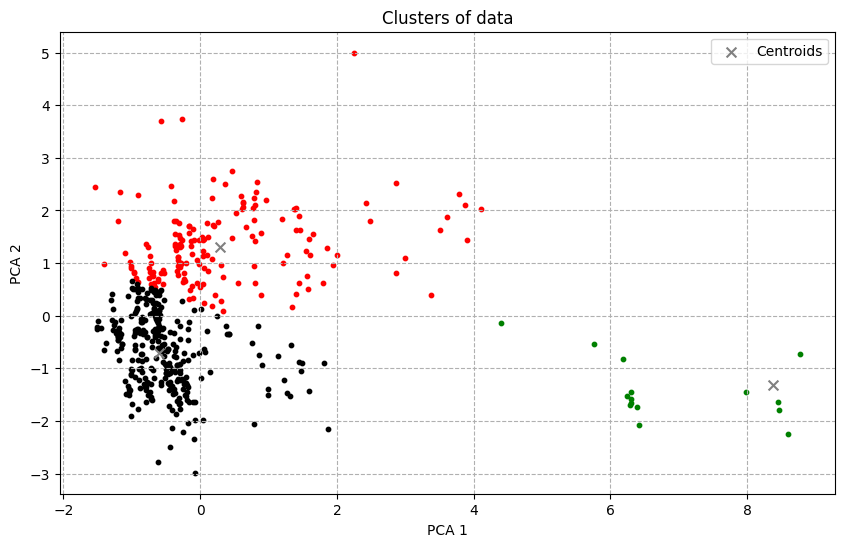

In [ ]:
plt.figure(figsize=(10, 6))
colors = ['red', 'black', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'brown']
for i in range(n_clusters):
    plt.scatter(X_pca[y_kmeans == i, 0], X_pca[y_kmeans == i, 1], s=10, c=colors[i])
    plt.scatter(pca1[y1_kmeans == i, 0], pca1[y1_kmeans == i, 1], s=10, c=colors[i])
    plt.scatter(pca2[y2_kmeans == i, 0], pca2[y2_kmeans == i, 1], s=10, c=colors[i] )
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='gray', label='Centroids', marker='x')
plt.grid(True, linestyle='--')
plt.title('Clusters of data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

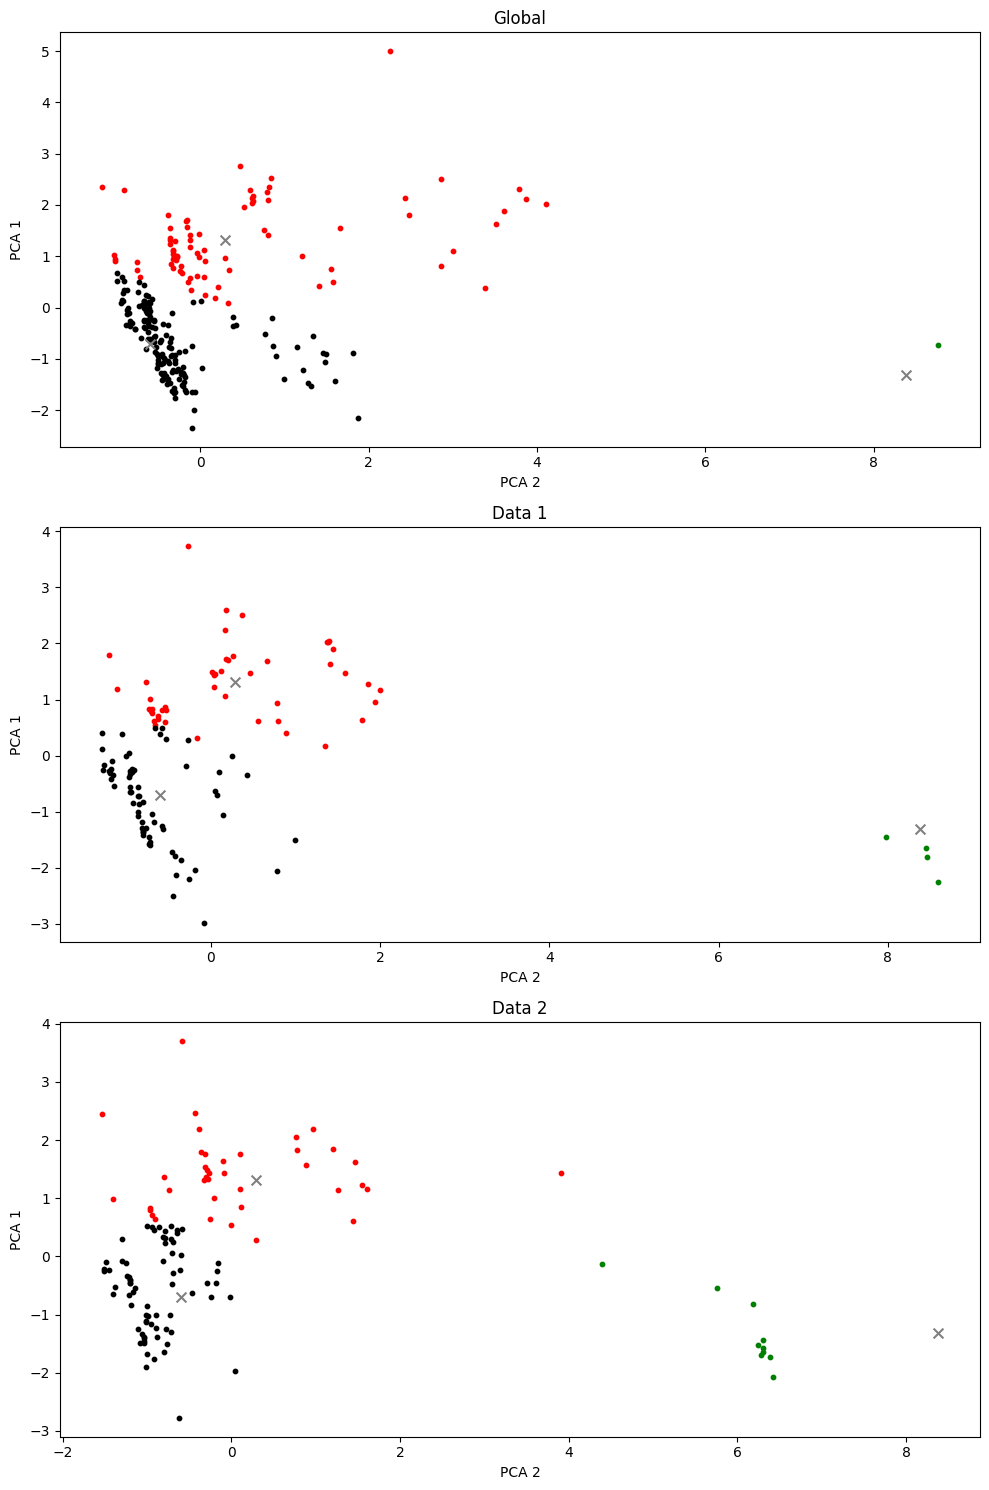

In [ ]:
colors = ['red', 'black', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'brown']

fig, axs = plt.subplots(n_clusters, figsize=(10, 15))

for j in range(n_clusters):
  dataPoints = X_pca if j==0 else pca1 if j==1 else pca2
  datalabels = y_kmeans if j==0 else y1_kmeans if j==1 else y2_kmeans
  for i in range(n_clusters):
      axs[j].scatter(dataPoints[datalabels == i, 0], dataPoints[datalabels == i, 1], s=10, c=colors[i], label=f'MI Cluster {i+1}')
  axs[j].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='gray', label='Centroids', marker='x')
    # Plot some data on the axes.
  axs[j].set_title('Global' if j==0 else f"Data {j}")  # Set title for the first subplot
  axs[j].set_xlabel('PCA 2')  # Set x label for the first subplot
  axs[j].set_ylabel('PCA 1')  # Set y label for the first subplot

# Adjust layout to make room for the titles and labels
plt.tight_layout()

plt.show()

Training Model Following 3 Cells have 3 different models, Logistic Regression, Naive Bayes and SVM. Run one of the Cells based on the model of our choice.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_pca, y_kmeans)

# Predicting the labels of the test set
y_pred = model.predict(pca1)

# Evaluating the model
accuracy = accuracy_score(y1_kmeans, y_pred)
print(f'Farmer 1 Logistic Regression Accuracy: {accuracy}')
# Predicting the labels of the test set
y_pred2 = model.predict(pca2)

# Evaluating the model
accuracy = accuracy_score(y2_kmeans, y_pred2)
print(f'Farmer 2 Logistic Regression Accuracy: {accuracy}')

Farmer 1 Logistic Regression Accuracy: 0.9833333333333333
Farmer 2 Logistic Regression Accuracy: 0.9752066115702479


In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_pca, y_kmeans)

# Predicting the labels of the test set
y_pred = model.predict(pca1)

# Evaluating the model
accuracy = accuracy_score(y1_kmeans, y_pred)
print(f'Farmer 1 Logistic Regression Accuracy: {accuracy}')
# Predicting the labels of the test set
y_pred2 = model.predict(pca2)

# Evaluating the model
accuracy = accuracy_score(y2_kmeans, y_pred2)
print(f'Farmer 2 Logistic Regression Accuracy: {accuracy}')

Farmer 1 Logistic Regression Accuracy: 0.9083333333333333
Farmer 2 Logistic Regression Accuracy: 0.9008264462809917


In [ ]:
from sklearn import svm
model = svm.SVC(kernel='linear')
model.fit(X_pca, y_kmeans)

# Predicting the labels of the test set
y_pred = model.predict(pca1)

# Evaluating the model
accuracy = accuracy_score(y1_kmeans, y_pred)
print(f'Farmer 1 Logistic Regression Accuracy: {accuracy}')
# Predicting the labels of the test set
y_pred2 = model.predict(pca2)

# Evaluating the model
accuracy = accuracy_score(y2_kmeans, y_pred2)
print(f'Farmer 2 Logistic Regression Accuracy: {accuracy}')

Farmer 1 Logistic Regression Accuracy: 1.0
Farmer 2 Logistic Regression Accuracy: 0.9917355371900827


Runing Accuracy Analysis for various values of Epsilions ranging from 10 to 55 with interval of 5

In [ ]:
epsilon = 10  # Privacy budget
acc = []
data = pca1
for i in range(10):
  print("Epsilon: ",epsilon)
  totalScore = 0
  noisy_X1 = np.zeros_like(data, dtype=float)
  sen = np.array(calculateSensitivities(pd.DataFrame(data)))
  esps = np.array([epsilon/len(sen)]*len(sen))
  scales = sen / esps
  # Add Laplace noise to each column of PCA data
  for i in range(data.shape[1]):
      # Generate Laplace noise
      noise = np.random.laplace(0, scales[i], size=data.shape[0])
      # Add noise to the column
      noisy_X1[:, i] = data[:, i] + noise

#    X_pca_laplas_Farm = laplace_mechanism_2d(pca_reload.transform(XFarm),epsilon)
  y_pred_original = model.predict(data)
  y_pred_noise = model.predict(noisy_X1)
  accuracy = accuracy_score(y1_kmeans, y_pred_noise)
  accuracy1 = accuracy_score(y_pred_original, y_pred_noise)
  print('Acc:' ,accuracy, 'Acc Original:',accuracy1)
  acc.append(accuracy)
  print("\n")
  epsilon = epsilon + 5

Epsilon:  10
Acc: 0.775 Acc Original: 0.7916666666666666


Epsilon:  15
Acc: 0.8333333333333334 Acc Original: 0.85


Epsilon:  20
Acc: 0.8333333333333334 Acc Original: 0.8333333333333334


Epsilon:  25
Acc: 0.9 Acc Original: 0.9


Epsilon:  30
Acc: 0.8333333333333334 Acc Original: 0.8333333333333334


Epsilon:  35
Acc: 0.8833333333333333 Acc Original: 0.8833333333333333


Epsilon:  40
Acc: 0.9333333333333333 Acc Original: 0.9333333333333333


Epsilon:  45
Acc: 0.9083333333333333 Acc Original: 0.9083333333333333


Epsilon:  50
Acc: 0.9416666666666667 Acc Original: 0.9416666666666667


Epsilon:  55
Acc: 0.9416666666666667 Acc Original: 0.9583333333333334




Power analysis for various values of Epsilon ranging from 10 to 110

In [ ]:
n_components = 2
pca_model = pcaGlobal
population = X

print("Researcher 1")
for n_pop in range(0, 2):
    power_df = exp_run(population,n_pop, pca_model,pca1)
    print("population",n_pop)
    print(power_df)

print("\nResearcher 2")
for n_pop in range(0, 2):
    power_df = exp_run(population,n_pop, pca_model,pca2)
    print("population",n_pop)
    print(power_df)

Researcher 1
population 0
    epsilon  power
0        10  0.500
1        20  0.625
2        30  0.675
3        40  0.925
4        50  0.750
5        60  0.800
6        70  0.725
7        80  0.950
8        90  0.875
9       100  0.625
10      110  0.850
population 1
    epsilon  power
0        10  0.525
1        20  0.525
2        30  0.575
3        40  0.875
4        50  0.600
5        60  0.700
6        70  0.675
7        80  0.575
8        90  0.800
9       100  0.575
10      110  0.775

Researcher 2
population 0
    epsilon  power
0        10  0.300
1        20  0.225
2        30  0.200
3        40  0.225
4        50  0.300
5        60  0.325
6        70  0.225
7        80  0.300
8        90  0.325
9       100  0.250
10      110  0.275
population 1
    epsilon  power
0        10  0.300
1        20  0.300
2        30  0.300
3        40  0.375
4        50  0.475
5        60  0.300
6        70  0.250
7        80  0.325
8        90  0.325
9       100  0.275
10      110  0.400


Researcher 1
0.40928442569389706 0.40928442569389706


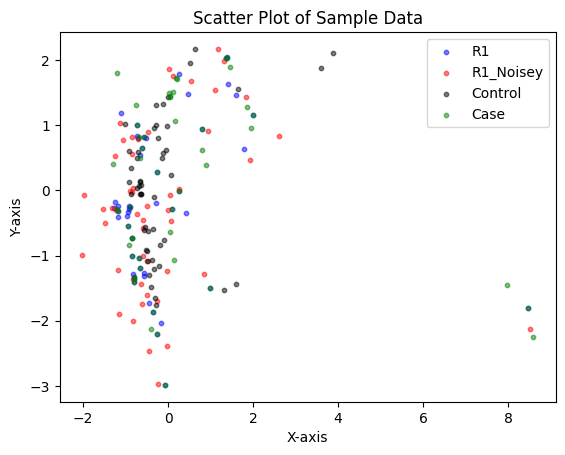

    Epsilon  Power  Noise Power  Accuracy
0        10    1.0         0.26      0.78
1        15    1.0         0.44      0.82
2        20    1.0         0.44      0.80
3        25    1.0         0.62      0.96
4        30    1.0         0.62      0.92
5        35    1.0         0.66      0.94
6        40    1.0         0.70      0.96
7        45    1.0         0.78      0.92
8        50    1.0         0.64      0.90
9        55    1.0         0.80      0.94
10       60    1.0         0.82      0.98


In [ ]:
def runAnalysis(data, pca_model,r1):
    power_results = []
    epsilon = 15
    size = 50
    researcher_1 = r1[np.random.choice(len(r1), size=size, replace=False)]
    control_group = X_pca[np.random.choice(len(X_pca), size=size, replace=False)]
    case_group = r1[np.random.choice(len(r1), size=size, replace=False)]

    for epsilon in range(10, 65, 5):
      researcher_1_noisy = addNoise(researcher_1, epsilon)

      y_pred_original = model.predict(researcher_1)
      y_pred_noise = model.predict(researcher_1_noisy)
      accuracy1 = accuracy_score(y_pred_original, y_pred_noise)

      control_distances = compute_euclidean_distances(researcher_1,control_group)
      control_distances1 = compute_euclidean_distances(researcher_1_noisy,control_group)

      threshold = determine_threshold(control_distances, 0.05)

      power = calculate_power(researcher_1_noisy, control_group, case_group, threshold)

      power_results.append((epsilon, power, accuracy1))

    print(threshold,threshold)
    plt.scatter(researcher_1[:,0], researcher_1[:,1], s=10, c='blue', alpha=0.5, label='R1')
    plt.scatter(researcher_1_noisy[:,0], researcher_1_noisy[:,1], s=10, c='red', alpha=0.5, label='R1_Noisey')
    plt.scatter(control_group[:,0], control_group[:,1], s=10, c='black', alpha=0.5, label='Control')
    plt.scatter(case_group[:,0], case_group[:,1], s=10, c='green', alpha=0.5, label='Case')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Scatter Plot of Sample Data')
    plt.legend()
    plt.show()

    power_df = pd.DataFrame(power_results, columns=['Epsilon', 'Noise Power', 'Accuracy'])
    return power_df

import matplotlib.pyplot as plt
n_components = 2
pca_model = pcaGlobal
population = X

print("Researcher 1")
power_df = runAnalysis(population, pca_model,pca1)
print(power_df)

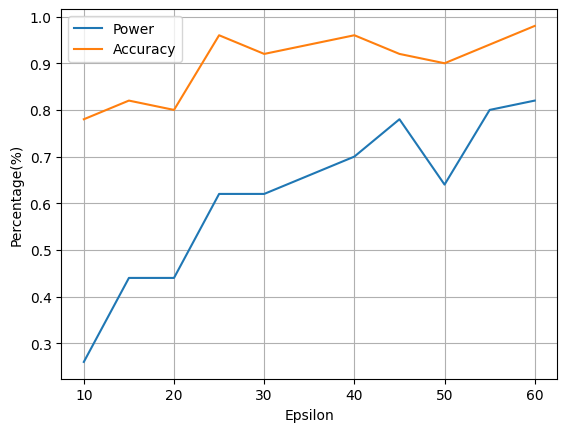

In [ ]:
plt.figure()
plt.plot(power_df['Epsilon'], power_df['Noise Power'], label='Power')
plt.plot(power_df['Epsilon'],  power_df['Accuracy'], label='Accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Percentage(%)')
plt.legend()
plt.grid(True)
plt.show()

Multiple Datasets

Choosing selectedShared farmer market samples

In [ ]:
researcher_1_noisy = addNoise(pca1, 55)
y_pred_noise = model.predict(researcher_1_noisy)
selectedItemsMarket1 = []
for idx in range(len(y_pred_noise)):
  if y_pred_noise[idx] == 1:
    selectedItemsMarket1.append(idx)

researcher_2_noisy = addNoise(pca2, 55)
y_pred_noise = model.predict(researcher_2_noisy)
selectedItemsMarket2 = []
for idx in range(len(y_pred_noise)):
  if y_pred_noise[idx] == 1:
    selectedItemsMarket2.append(idx)


Getting Sales Data

In [ ]:
df_MI_1_Sales = df_MI_1['Sales'].values
df_MI_1_Sales = df_MI_1_Sales[selectedItemsMarket1]

df_MI_2_Sales = df_MI_2['Sales'].values
df_MI_2_Sales = df_MI_2_Sales[selectedItemsMarket2]

last 36 weeks Sales data

In [ ]:
df_MI_1_Sales = df_MI_1_Sales[len(df_MI_1_Sales)-36:]
df_MI_2_Sales = df_MI_2_Sales[len(df_MI_2_Sales)-36:]

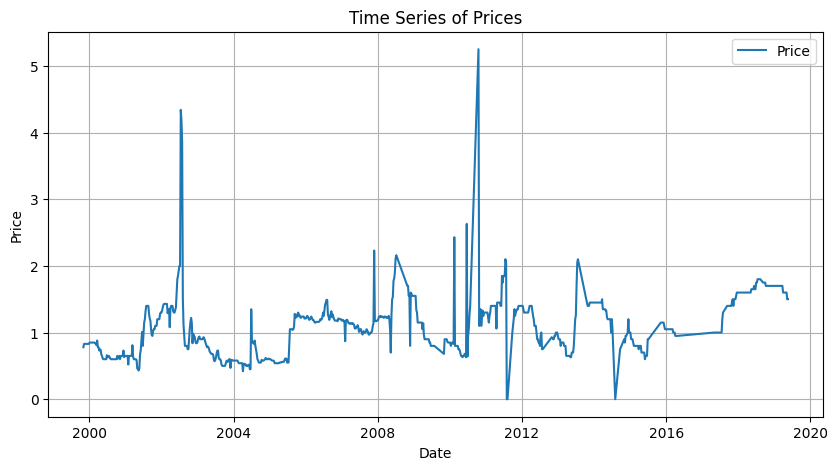

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('ProductPriceIndex.csv')
df = df.loc[:, df.columns.intersection(['productname', 'date','farmprice'])]
df = df.loc[df['productname'] == 'Potatoes'].drop(columns=['productname'])
df['farmprice'] = df['farmprice'].str.replace('$','')
df['farmprice'] = df['farmprice'].astype(float)
df['date'] = pd.to_datetime(df['date'])

# Set the 'Date' column as the index of the dataframe
df.set_index('date', inplace=True)

# Plotting the data
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(df['farmprice'], label='Price')  # Plot the 'Price' column
plt.title('Time Series of Prices')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Price')  # Y-axis label
plt.legend()  # Add a legend (optional)
plt.grid(True)  # Add grid for better readability (optional)
plt.yscale('linear')
# Show the plot
plt.show()


<ipython-input-33-8f5168fb30fd>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_36_weeks['week_number'] = (df_last_36_weeks['date'] - start_date).dt.days // 7


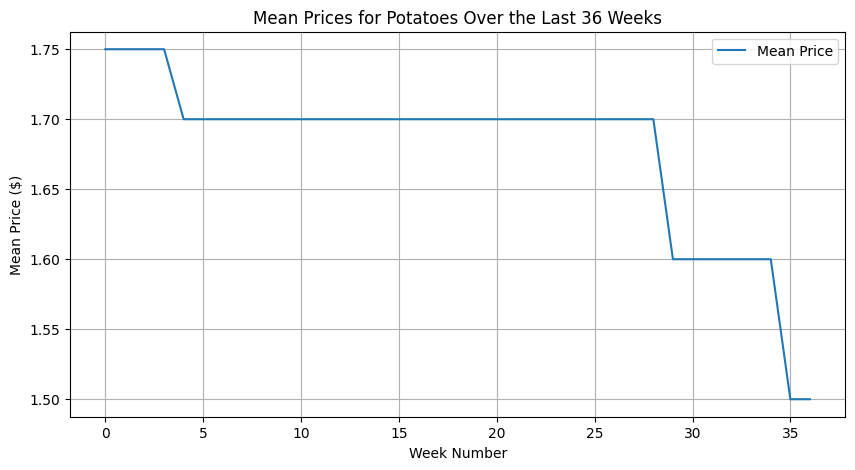

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('ProductPriceIndex.csv')

# Filter for required columns and rows where 'productname' is 'Potatoes'
df = df.loc[df['productname'] == 'Potatoes', ['productname', 'date', 'farmprice']]

# Remove the dollar sign from the 'farmprice' column and convert it to float
df['farmprice'] = df['farmprice'].str.replace('$', '').astype(float)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter the DataFrame to the last 36 weeks of the year 2018
start_date = df['date'].max() - pd.Timedelta(weeks=36)
df_last_36_weeks = df[(df['date'] >= start_date) & (df['date'] <= df['date'].max())]

# Convert dates to week numbers relative to the last 36 weeks
df_last_36_weeks['week_number'] = (df_last_36_weeks['date'] - start_date).dt.days // 7

# Calculate the mean price per week
weekly_mean_price = df_last_36_weeks.groupby('week_number')['farmprice'].mean().reset_index()

# Plotting the data
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(weekly_mean_price['week_number'], weekly_mean_price['farmprice'], label='Mean Price')  # Plot the mean price per week
plt.title('Mean Prices for Potatoes Over the Last 36 Weeks')  # Title of the plot
plt.xlabel('Week Number')  # X-axis label
plt.ylabel('Mean Price ($)')  # Y-axis label
plt.legend()  # Add a legend (optional)
plt.grid(True)  # Add grid for better readability (optional)
plt.yscale('linear')

# Show the plot
plt.show()


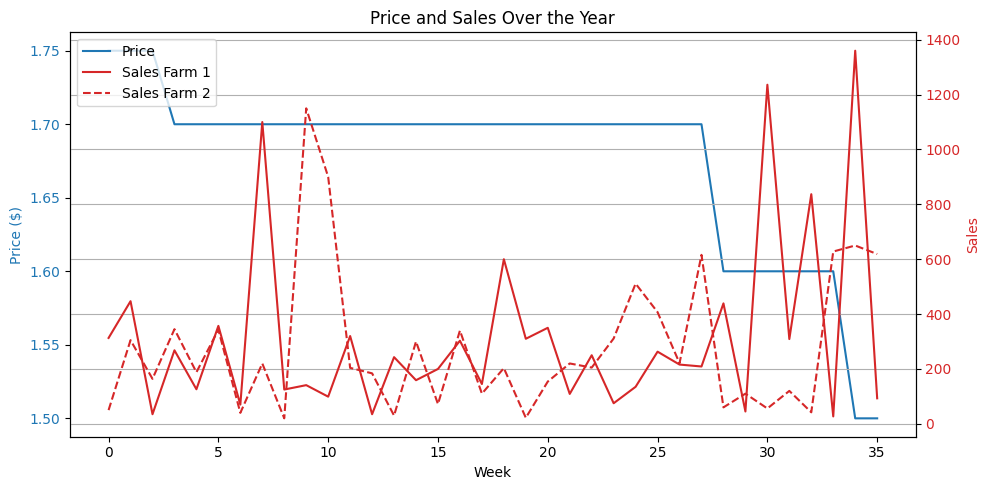

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = {
    'Week': range(0, 36),  # Assuming 52 weeks in the year
    'Price': weekly_mean_price['farmprice'].values[1:],
    'Sales1': df_MI_1_Sales,
    'Sales2' : df_MI_2_Sales
}
df = pd.DataFrame(data)

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Price on primary y-axis
ax1.set_xlabel('Week')
ax1.set_ylabel('Price ($)', color='tab:blue')
lns1 = ax1.plot(df['Week'], df['Price'], color='tab:blue', label='Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Sales', color='tab:red')
lns2 = ax2.plot(df['Week'], df['Sales1'], color='tab:red', label='Sales Farm 1')
lns3 = ax2.plot(df['Week'], df['Sales2'], color='tab:red', linestyle='dashed', label='Sales Farm 2')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title
plt.title('Price and Sales Over the Year')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)

# Show plot
fig.tight_layout()  # Adjust layout to prevent overlap
plt.grid(True, which='major', axis='both')
plt.show()


In [ ]:
df1 = pd.read_csv('Final_Pulse_Data.csv')
df1['Week'].unique()

In [ ]:
cols = list(df1.columns[:4])
cols.append('Week')
cols.append('Location')
df1 = df1[cols]
df1['Week'] = df1['Week'].str.replace('week','')
df1 = df1.loc[df1['Location'] == 'WI'].drop(columns=['Location'])
df1 = df1[cols[:-1]].astype(float)
df1['sum'] = df1.sum(axis=1)
for i in range(4):
  df1[df1.columns[i]] = df1[df1.columns[i]] / df1['sum']
print(list(df1['Week'].unique()))

In [ ]:
df1

In [ ]:
newData = []
for w in range(1,37):
  row = [w]
  for i in range(4):
    row.append(df1.loc[df1['Week'] == float(w)].loc[:, df1.columns[i]].mean())
  newData.append(row)
newDF = pd.DataFrame(newData, columns=['Week','0','1','2','3'])
newDF

In [ ]:

# Plotting the data
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(newDF['0'], label='Insecurity Level 0')  # Plot the 'Price' column
plt.plot(newDF['1'], label='Insecurity Level 1')  # Plot the 'Price' column
plt.plot(newDF['2'], label='Insecurity Level 2')  # Plot the 'Price' column
plt.plot(newDF['3'], label='Insecurity Level 3')  # Plot the 'Price' column
plt.title('Time Series of Insecurity')  # Title of the plot
plt.xlabel('Week')  # X-axis label
plt.ylabel('Percentage/100')  # Y-axis label
plt.legend()  # Add a legend (optional)
plt.grid(True)  # Add grid for better readability (optional)
plt.yscale('linear')
# Show the plot
plt.show()

In [ ]:
newDF.to_csv('Insecurity_Data.csv', index=False)